In [ ]:
import os
import time
import requests
import tempfile
import numpy as np
import nibabel as nib
from typing import List, Tuple, Dict, Any, Optional

In [12]:
class OpenNeuroStreamer:
    """A class to stream fMRI data from the OpenNeuro S3 bucket."""
    def __init__(self, dataset_id: str = "ds002306"):
        self.dataset_id = dataset_id
        self.base_url = f"https://s3.amazonaws.com/openneuro.org/{dataset_id}"

    def check_url_exists(self, url: str) -> bool:
        try:
            response = requests.head(url, timeout=15)
            return response.status_code == 200
        except requests.exceptions.RequestException:
            return False

    def stream_nii_file(self, url: str, chunk_size: int = 8192) -> Optional[np.ndarray]:
        print(f"📥 Streaming: {url.split('/')[-1]}")
        temp_path = None
        try:
            response = requests.get(url, stream=True, timeout=60)
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            downloaded_size = 0
            with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as temp_file:
                temp_path = temp_file.name
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        temp_file.write(chunk)
                        downloaded_size += len(chunk)
                        if total_size > 0:
                            progress = (downloaded_size / total_size) * 100
                            print(f"\r📊 Progress: {progress:.1f}% ({downloaded_size/(1024*1024):.1f}MB / {total_size/(1024*1024):.1f}MB)", end="")
            print()
            img = nib.load(temp_path)
            data = img.get_fdata(dtype=np.float32)
            print(f"Loaded. Shape: {data.shape}, Type: {data.dtype}")
            return data
        except Exception as e:
            print(f"Error loading {url}: {str(e)}")
            return None
        finally:
            if temp_path and os.path.exists(temp_path):
                os.unlink(temp_path)

    def load_multiple_subjects(self,
                             subjects: Optional[List[str]] = None,
                             max_files: int = 5,
                             task_type: str = "training") -> List[Tuple[str, np.ndarray]]:
        if subjects is None:
            subjects = [f"sub-0{i}" for i in range(1, 4)]
        loaded_data = []
        file_count = 0
        for subject in subjects:
            if file_count >= max_files: break
            for run_num in range(1, 6):
                if file_count >= max_files: break
                url = f"{self.base_url}/{subject}/func/{subject}_task-{task_type}_run-{run_num:02d}_bold.nii.gz"
                if not self.check_url_exists(url):
                    print(f"File not found, skipping: {url}")
                    continue
                data = self.stream_nii_file(url)
                if data is not None:
                    filename = os.path.basename(url)
                    loaded_data.append((filename, data))
                    file_count += 1
                time.sleep(0.5) # Sunucuyu yormamak için kısa bir bekleme
        return loaded_data


# ===================================================================
# Initial loading data from Open Neuro
# ===================================================================
def run_data_loading_experiment(max_files_to_load=10):
    """
    Manages the data download process by uploading a specified number of files.
    """
    print("OpenNeuro ds002306 Streaming Data Loader")
    print("=" * 50)
    
    streamer = OpenNeuroStreamer("ds002306")
    
    # Bu katılımcılardan veri çekmeye çalışacağız
    subjects_to_load_from = ["sub-01", "sub-02", "sub-03", "sub-04"]
    
    print(f"Loading data (max {max_files_to_load} files) from subjects: {subjects_to_load_from}...")
    
    # The actual command that downloads the data
    data_list = streamer.load_multiple_subjects(
        subjects=subjects_to_load_from,
        max_files=max_files_to_load,
        task_type="training"
    )

    if not data_list:
        print("\nNo data was loaded. Please check your internet connection or the file URLs.")
        return None

    print(f"\n Successfully loaded {len(data_list)} files.")
    total_size_mb = 0
    for filename, data in data_list:
        size_mb = data.nbytes / (1024 * 1024)
        total_size_mb += size_mb
        print(f"   - 📁 {filename}")
        print(f"     - Shape: {data.shape}")
        print(f"     - Size: {size_mb:.2f} MB")

    print(f"\n Total loaded data size into RAM: {total_size_mb:.2f} MB")
    
    return data_list



loaded_fmri_data = run_data_loading_experiment(max_files_to_load=10)

🧠 OpenNeuro ds002306 Streaming Data Loader
🔄 Loading data (max 10 files) from subjects: ['sub-01', 'sub-02', 'sub-03', 'sub-04']...
📥 Streaming: sub-01_task-training_run-01_bold.nii.gz
📊 Progress: 100.0% (202.2MB / 202.2MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub-01_task-training_run-02_bold.nii.gz
📊 Progress: 100.0% (202.4MB / 202.4MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub-01_task-training_run-03_bold.nii.gz
📊 Progress: 100.0% (203.1MB / 203.1MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub-01_task-training_run-04_bold.nii.gz
📊 Progress: 100.0% (203.6MB / 203.6MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub-01_task-training_run-05_bold.nii.gz
📊 Progress: 100.0% (203.7MB / 203.7MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub-02_task-training_run-01_bold.nii.gz
📊 Progress: 100.0% (204.5MB / 204.5MB)
✅ Loaded. Shape: (96, 96, 72, 281), Type: float32
📥 Streaming: sub

🚀 Launching fMRI Data Analysis...

📋 fMRI DATA ANALYSIS REPORT
📊 CURRENT DATA SUMMARY
📁 FILE 1: sub-01_task-training_run-01_bold.nii.gz
   - Shape: (96, 96, 72, 281)
     - Spatial (X, Y, Z): 96 x 96 x 72
     - Temporal (T):      281 timepoints
   - Size: 711.28 MB
   - Voxel Value Range: 0.00 to 2193.00

📁 FILE 2: sub-01_task-training_run-02_bold.nii.gz
   - Shape: (96, 96, 72, 281)
     - Spatial (X, Y, Z): 96 x 96 x 72
     - Temporal (T):      281 timepoints
   - Size: 711.28 MB
   - Voxel Value Range: 0.00 to 2221.00

📁 FILE 3: sub-01_task-training_run-03_bold.nii.gz
   - Shape: (96, 96, 72, 281)
     - Spatial (X, Y, Z): 96 x 96 x 72
     - Temporal (T):      281 timepoints
   - Size: 711.28 MB
   - Voxel Value Range: 0.00 to 2147.00

📁 FILE 4: sub-01_task-training_run-04_bold.nii.gz
   - Shape: (96, 96, 72, 281)
     - Spatial (X, Y, Z): 96 x 96 x 72
     - Temporal (T):      281 timepoints
   - Size: 711.28 MB
   - Voxel Value Range: 0.00 to 2182.00

📁 FILE 5: sub-01_task-trai

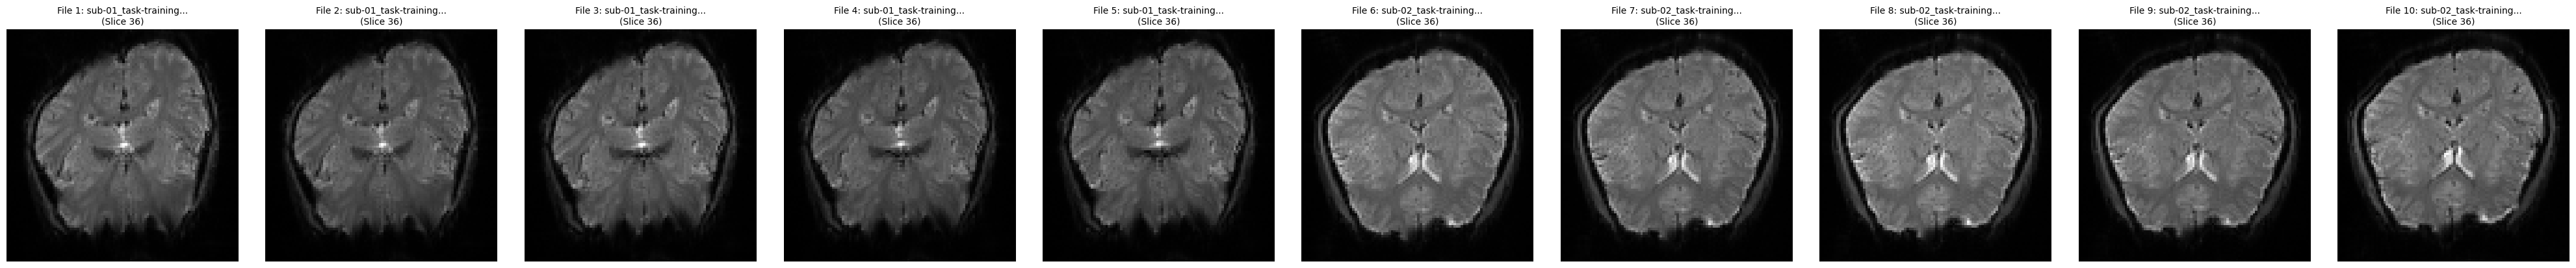


   b) Voxel Intensity Distribution (from a sample of voxels)


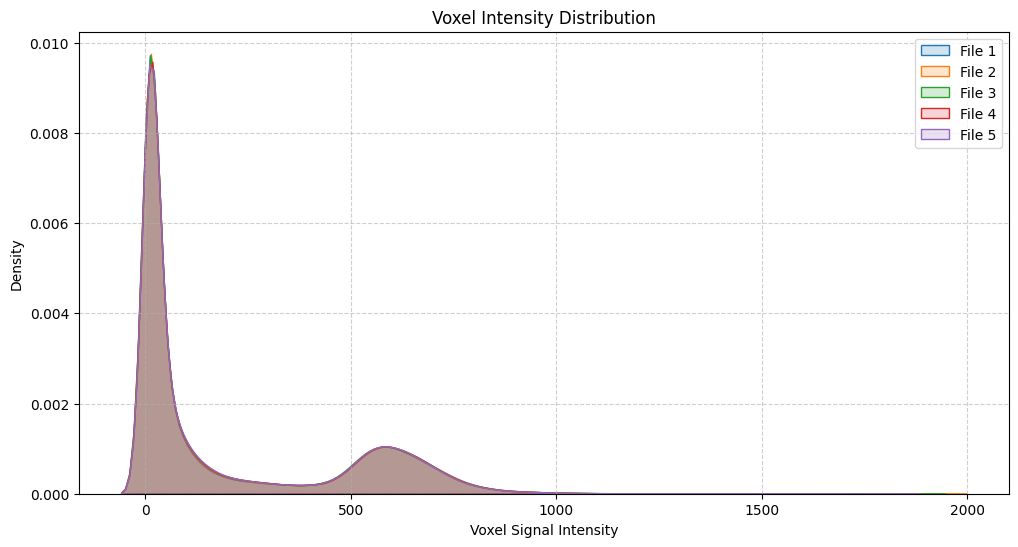

   (Note: The peak near zero often represents background voxels outside the brain.)

   c) Temporal Signal Trace for a Central Voxel


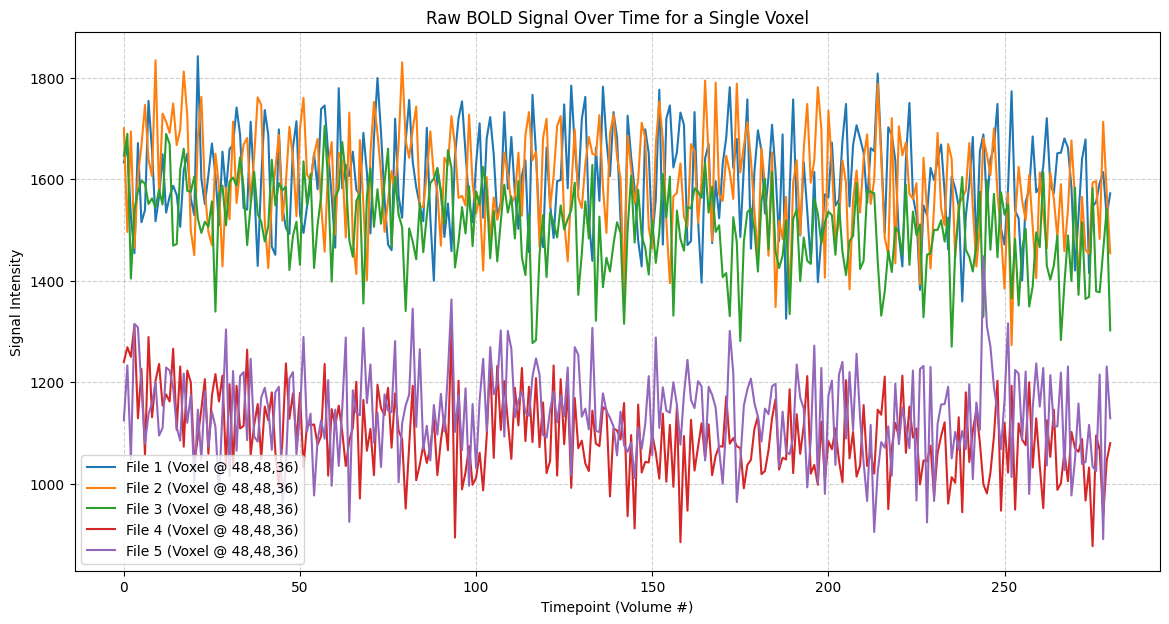


✅ Analysis complete.
💡 Next steps: Preprocessing (e.g., resampling, normalization) and model building.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

class fMRIDataAnalyzer:
    """
    A class to analyze and visualize loaded fMRI data.
    Provides insights into data structure, dimensions, and potential preprocessing strategies.
    """

    def __init__(self, loaded_data: List[Tuple[str, np.ndarray]]):
        """
        Initializes the analyzer with the loaded data.
        Args:
            loaded_data (List[Tuple[str, np.ndarray]]): A list of (filename, data_array) tuples.
        """
        if not loaded_data:
            raise ValueError("Input 'loaded_data' cannot be empty.")
        self.loaded_data = loaded_data
        self.filenames = [item[0] for item in loaded_data]
        self.data_arrays = [item[1] for item in loaded_data]
        self.TR = 2.0  # Repetition Time in seconds, a common value. Update if known.

    def show_data_summary(self):
        """Displays a clear summary of the currently loaded data."""
        print(" CURRENT DATA SUMMARY")
        print("=" * 50)

        total_size_mb = sum(data.nbytes / (1024*1024) for data in self.data_arrays)
        total_timepoints = sum(data.shape[3] for data in self.data_arrays)

        for i, (filename, data) in enumerate(self.loaded_data):
            size_mb = data.nbytes / (1024*1024)
            print(f"FILE {i+1}: {filename}")
            print(f"   - Shape: {data.shape}")
            print(f"     - Spatial (X, Y, Z): {data.shape[0]} x {data.shape[1]} x {data.shape[2]}")
            print(f"     - Temporal (T):      {data.shape[3]} timepoints")
            print(f"   - Size: {size_mb:.2f} MB")
            print(f"   - Voxel Value Range: {data.min():.2f} to {data.max():.2f}")
            print()

        print(" AGGREGATE STATISTICS:")
        print(f"   - Total Files: {len(self.loaded_data)}")
        print(f"   - Total Size in RAM: {total_size_mb:.2f} MB ({total_size_mb/1024:.2f} GB)")
        print(f"   - Total Timepoints (3D Volumes): {total_timepoints:,}")

    def explain_data_structure(self):
        """Provides a high-level explanation of the 4D fMRI data structure."""
        print("\n EXPLANATION OF fMRI DATA STRUCTURE")
        print("=" * 50)
        if not self.data_arrays: return

        print("This dataset consists of 4-dimensional arrays, with the following structure:")
        print("  - Dimensions 1, 2, 3 (X, Y, Z): These form a 3D 'volume' or 'scan', representing a snapshot of the brain at one point in time.")
        print("  - Dimension 4 (Time): This is a series of the 3D volumes captured sequentially, showing how brain activity evolves.")
        print()
        print("Key Concepts:")
        print("  - Each file represents one fMRI 'run' or 'scan'.")
        print("  - A 'voxel' is the 3D equivalent of a pixel; it's the smallest unit of your 3D brain image.")
        
        sample_shape = self.data_arrays[0].shape
        scan_time_minutes = (sample_shape[3] * self.TR) / 60
        print(f"  - Assuming a Repetition Time (TR) of {self.TR}s, a scan with {sample_shape[3]} timepoints lasts approximately {scan_time_minutes:.1f} minutes.")

    def discuss_concatenation_strategies(self):
        """Outlines different strategies for combining multiple fMRI runs for model training."""
        print("\n DATA COMBINATION STRATEGIES FOR DEEP LEARNING")
        print("=" * 50)
        if not self.data_arrays: return

        spatial_shapes = [data.shape[:3] for data in self.data_arrays]
        all_same_spatial = all(shape == spatial_shapes[0] for shape in spatial_shapes)

        print(f"Spatial dimensions are consistent across all files: {'Yes' if all_same_spatial else ' No'}")
        if not all_same_spatial:
            print("WARNING: Files have different spatial dimensions. They must be resampled to a common shape before concatenation.")
            return

        print("\nThree common strategies for handling multiple runs:")
        print("\n⃣ CONCATENATE ALONG TIME AXIS")
        print("   - Method: Create one long time-series from all runs.")
        print("   - Code: `np.concatenate(list_of_arrays, axis=3)`")
        print("   - Use Case: When you want to treat all data as a single, continuous stream. Not ideal if runs have different underlying noise properties or if you need to separate train/validation sets by run.")

        print("\n STACK INTO A BATCH DIMENSION")
        print("   - Method: Create a new 5D tensor where the first dimension is the 'batch' or 'run' index.")
        print("   - Code: `np.stack(list_of_arrays, axis=0)`")
        print("   - Use Case: This is the most common and flexible approach for deep learning. It keeps runs separate, making it easy to create batches and split data into train/validation/test sets (e.g., use 8 runs for training, 2 for validation).")

        print("\n KEEP AS A LIST OF ARRAYS")
        print("   - Method: Do not combine. Keep the data in a Python list.")
        print("   - Code: `[run1_array, run2_array, ...]`")
        print("   - Use Case: Useful for custom data generators or when runs have different lengths (temporal dimension), as `np.stack` would fail.")

    ### NEW FEATURE: Added plots for intensity and temporal signal ###
    def visualize_data_properties(self):
        """Creates visualizations to give an overview of the data."""
        print("\n DATA VISUALIZATION")
        print("=" * 50)
        if not self.data_arrays: return

        # --- 1. Central Slice Visualization ---
        print("   a) Central Axial Slice from the First Timepoint of Each Run")
        num_files = len(self.loaded_data)
        fig, axes = plt.subplots(1, num_files, figsize=(4 * num_files, 4), squeeze=False)
        for i, (filename, data) in enumerate(self.loaded_data):
            mid_slice_z = data.shape[2] // 2
            slice_data = data[:, :, mid_slice_z, 0]
            
            axes[0, i].imshow(np.rot90(slice_data), cmap='gray', origin='lower')
            axes[0, i].set_title(f"File {i+1}: {filename[:20]}...\n(Slice {mid_slice_z})", fontsize=10)
            axes[0, i].axis('off')
        plt.tight_layout()
        plt.show()

        # --- 2. Voxel Intensity Distribution ---
        print("\n   b) Voxel Intensity Distribution (from a sample of voxels)")
        plt.figure(figsize=(12, 6))
        for i, data in enumerate(self.data_arrays[:5]): # Plot for first 5 files to avoid clutter
            # Flatten and take a random sample to make plotting faster
            sample_voxels = data.flatten()
            if sample_voxels.size > 500000:
                 sample_voxels = np.random.choice(sample_voxels, 500000, replace=False)
            sns.kdeplot(sample_voxels, label=f'File {i+1}', fill=True, alpha=0.2)
        plt.title('Voxel Intensity Distribution')
        plt.xlabel('Voxel Signal Intensity')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("   (Note: The peak near zero often represents background voxels outside the brain.)")

        # --- 3. Mean Signal Over Time (Central Voxel) ---
        print("\n   c) Temporal Signal Trace for a Central Voxel")
        plt.figure(figsize=(14, 7))
        for i, data in enumerate(self.data_arrays[:5]): # Plot for first 5 files
            cx, cy, cz = [d // 2 for d in data.shape[:3]]
            voxel_timeseries = data[cx, cy, cz, :]
            plt.plot(voxel_timeseries, label=f'File {i+1} (Voxel @ {cx},{cy},{cz})')
        plt.title('Raw BOLD Signal Over Time for a Single Voxel')
        plt.xlabel('Timepoint (Volume #)')
        plt.ylabel('Signal Intensity')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    def generate_full_report(self):
        """Generates a complete analysis report by calling all other methods."""
        print("\n" + "="*60)
        print(" fMRI DATA ANALYSIS REPORT")
        print("="*60)

        self.show_data_summary()
        self.explain_data_structure()
        self.discuss_concatenation_strategies()
        self.visualize_data_properties()

        print("\n Analysis complete.")
        print("Next steps: Preprocessing (e.g., resampling, normalization) and model building.")


# ===================================================================
# Helper function to run the analysis
# ===================================================================
def analyze_loaded_data(loaded_fmri_data: List[Tuple[str, np.ndarray]]):
    """
    A convenient wrapper to run the full analysis on loaded data.
    """
    if not loaded_fmri_data or not isinstance(loaded_fmri_data, list):
        print("'loaded_fmri_data' variable not found or is not a list.")
        print( Please ensure the data loading script has run successfully first.")
        return None
    
    try:
        print(" Launching fMRI Data Analysis...")
        analyzer = fMRIDataAnalyzer(loaded_fmri_data)
        analyzer.generate_full_report()
        return analyzer
    except Exception as e:
        print(f"An error occurred during analysis: {e}")
        return None



if 'loaded_fmri_data' in locals():
     analyzer_instance = analyze_loaded_data(loaded_fmri_data)
else:
     print("Data not loaded yet. Please run the data loading cell first.")



🚀 Starting data analysis...

📋 fMRI DATA ANALYSIS REPORT
📊 CURRENT DATA STATUS
📁 FILE 1:
   Name: sub-01_task-training_run-01_bold.nii.gz
   Shape: (96, 96, 72, 281)
   └── X (width): 96 voxels
   └── Y (height): 96 voxels
   └── Z (depth): 72 slices
   └── T (time): 281 timepoints
   Size: 711.3 MB
   Total Voxels: 186,458,112

📁 FILE 2:
   Name: sub-01_task-training_run-02_bold.nii.gz
   Shape: (96, 96, 72, 281)
   └── X (width): 96 voxels
   └── Y (height): 96 voxels
   └── Z (depth): 72 slices
   └── T (time): 281 timepoints
   Size: 711.3 MB
   Total Voxels: 186,458,112

📁 FILE 3:
   Name: sub-01_task-training_run-03_bold.nii.gz
   Shape: (96, 96, 72, 281)
   └── X (width): 96 voxels
   └── Y (height): 96 voxels
   └── Z (depth): 72 slices
   └── T (time): 281 timepoints
   Size: 711.3 MB
   Total Voxels: 186,458,112

📁 FILE 4:
   Name: sub-01_task-training_run-04_bold.nii.gz
   Shape: (96, 96, 72, 281)
   └── X (width): 96 voxels
   └── Y (height): 96 voxels
   └── Z (depth): 72 

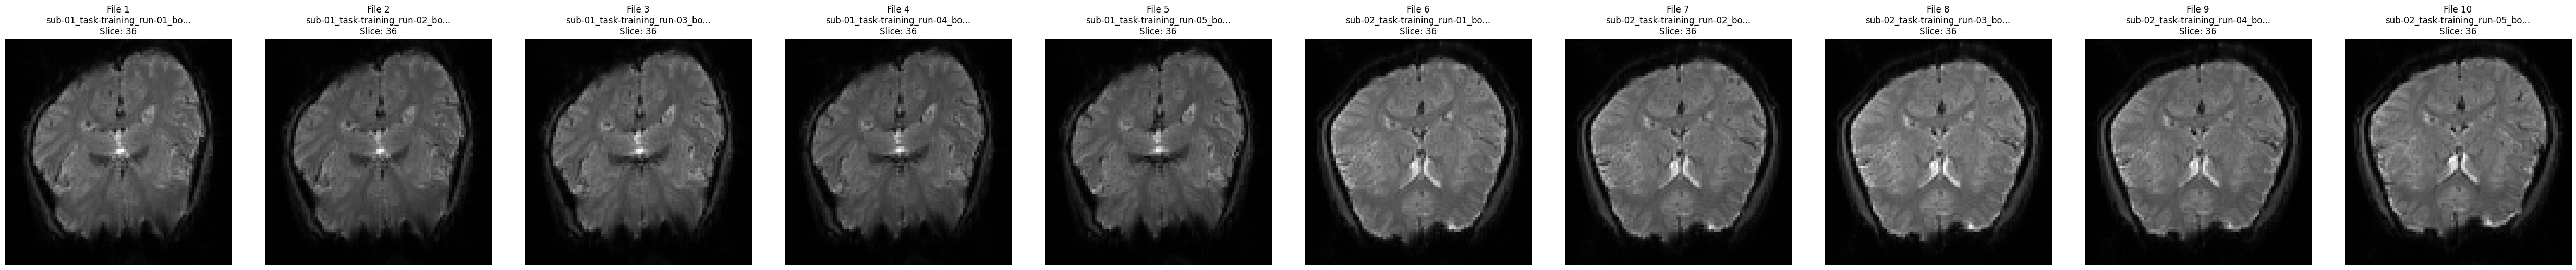


📋 FILE SUMMARY TABLE:
--------------------------------------------------------------------------------
File #   Shape                     Timepoints   Size (MB)    Duration (min) 
--------------------------------------------------------------------------------
1        (96, 96, 72, 281)         281          711.3        9.4            
2        (96, 96, 72, 281)         281          711.3        9.4            
3        (96, 96, 72, 281)         281          711.3        9.4            
4        (96, 96, 72, 281)         281          711.3        9.4            
5        (96, 96, 72, 281)         281          711.3        9.4            
6        (96, 96, 72, 281)         281          711.3        9.4            
7        (96, 96, 72, 281)         281          711.3        9.4            
8        (96, 96, 72, 281)         281          711.3        9.4            
9        (96, 96, 72, 281)         281          711.3        9.4            
10       (96, 96, 72, 281)         281       

In [14]:
# ===================================================================
# fMRI Data Analyzer (Original Structure, Translated)
# ===================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

class fMRIDataAnalyzer:
    """
    A clean class to analyze and visualize fMRI data.
    """

    def __init__(self, loaded_data: List[Tuple[str, np.ndarray]]):
        """
        Initializes the analyzer with loaded data.
        Args:
            loaded_data (List[Tuple[str, np.ndarray]]): A list containing (filename, data_array) tuples.
        """
        self.loaded_data = loaded_data
        self.filenames = [item[0] for item in loaded_data]
        self.data_arrays = [item[1] for item in loaded_data]

    def show_current_data_status(self):
        """Clearly displays the status of the current data."""
        print("📊 CURRENT DATA STATUS")
        print("=" * 50)

        total_size_mb = 0
        total_timepoints = 0

        for i, (filename, data) in enumerate(self.loaded_data):
            size_mb = data.nbytes / (1024*1024)
            total_size_mb += size_mb
            total_timepoints += data.shape[3]

            print(f"📁 FILE {i+1}:")
            print(f"   Name: {filename}")
            print(f"   Shape: {data.shape}")
            print(f"   └── X (width): {data.shape[0]} voxels")
            print(f"   └── Y (height): {data.shape[1]} voxels")
            print(f"   └── Z (depth): {data.shape[2]} slices")
            print(f"   └── T (time): {data.shape[3]} timepoints")
            print(f"   Size: {size_mb:.1f} MB")
            print(f"   Total Voxels: {np.prod(data.shape):,}")
            print()

        print(f"🔢 TOTALS:")
        print(f"   Number of files: {len(self.loaded_data)}")
        print(f"   Total size: {total_size_mb:.1f} MB ({total_size_mb/1024:.1f} GB)")
        print(f"   Total timepoints: {total_timepoints}")

    def explain_data_structure(self):
        """Explains the data structure."""
        print("\n DATA STRUCTURE EXPLAINED")
        print("=" * 50)

        if self.data_arrays:
            print(" Each file is 4-dimensional:")
            print("   • X, Y, Z = 3D brain volume (spatial)")
            print("   • T = Time dimension (temporal)")
            print()
            print(" This data represents:")
            print("   • Each file = 1 fMRI run (a single session)")
            print("   • Each timepoint = 1 full brain scan (takes ~2-3 seconds)")
            print("   • Each voxel = A small portion of the brain")
            print()

            sample_shape = self.data_arrays[0].shape
            # Assuming TR (Repetition Time) is ~2.0 seconds for this dataset
            scan_time = sample_shape[3] * 2.0 / 60
            print(f" Estimated scan time per file: ~{scan_time:.1f} minutes")

    def combine_data_options(self):
        """Shows data combination options."""
        print("\n DATA COMBINATION OPTIONS")
        print("=" * 50)

        if not self.data_arrays:
            print(" No data to combine.")
            return

        spatial_shapes = [data.shape[:3] for data in self.data_arrays]
        all_same_spatial = all(shape == spatial_shapes[0] for shape in spatial_shapes)

        print(f"📊 Spatial dimensions are consistent: {' Yes' if all_same_spatial else ' No'}")

        if all_same_spatial:
            print("\n Combination options:")
            print()

            total_timepoints = sum(data.shape[3] for data in self.data_arrays)
            combined_shape_temporal = (*spatial_shapes[0], total_timepoints)
            # Assuming float32 (4 bytes), not float64 (8 bytes) as data was loaded this way
            combined_size_gb = np.prod(combined_shape_temporal) * 4 / (1024**3)

            print(" COMBINE ON TIME AXIS:")
            print(f"   Method: np.concatenate(axis=3)")
            print(f"   Resulting shape: {combined_shape_temporal}")
            print(f"   Estimated size: {combined_size_gb:.1f} GB")
            print(f"   Advantage: Creates a single long time-series.")
            print(f"   Use Case: Training on continuous data.")
            print()

            print(" KEEP AS A LIST:")
            print("   Method: Keep as separate files in a list.")
            print("   Advantage: Flexible for batch processing.")
            print("   Use Case: Splitting into train/validation/test sets.")
            print()
            
            # Note: A timepoint dimension must be consistent for np.stack
            timepoints = [data.shape[3] for data in self.data_arrays]
            all_same_temporal = all(t == timepoints[0] for t in timepoints)
            
            print("COMBINE ON BATCH DIMENSION:")
            print("   Method: np.stack() to create a 5D tensor.")
            if all_same_temporal:
                print(f"   Resulting shape: ({len(self.data_arrays)}, {self.data_arrays[0].shape[0]}, {self.data_arrays[0].shape[1]}, {self.data_arrays[0].shape[2]}, {self.data_arrays[0].shape[3]})")
            else:
                 print("   Resulting shape: (num_files, X, Y, Z, time) - Note: time dimension must be the same for all files to stack.")
            print("   Advantage: Ideal for batch processing.")
            print("   Use Case: Standard for deep learning models.")

        else:
            print(" Spatial dimensions differ - preprocessing is required.")

    def demonstrate_concatenation(self):
        """Shows concatenation examples."""
        print("\n💡 CONCATENATION EXAMPLES")
        print("=" * 50)

        if len(self.data_arrays) < 2:
            print(" At least 2 files are needed for this demonstration.")
            return

        print("🔧 Code examples:")
        print()
        print("# 1. Combine on the time axis:")
        print("combined_temporal = np.concatenate([")
        for i, filename in enumerate(self.filenames):
            print(f"    data_arrays[{i}],  # {filename}")
        print("], axis=3)")
        combined_shape = (*self.data_arrays[0].shape[:3], sum(d.shape[3] for d in self.data_arrays))
        print(f"# Resulting shape: {combined_shape}")
        print()

        # Check if stacking is possible
        timepoints = [data.shape[3] for data in self.data_arrays]
        if all(t == timepoints[0] for t in timepoints):
            print("# 2. Stack into a batch dimension:")
            print("batch_data = np.stack([")
            for i, filename in enumerate(self.filenames):
                print(f"    data_arrays[{i}],  # {filename}")
            print("], axis=0)")
            print(f"# Resulting shape: ({len(self.data_arrays)}, *{self.data_arrays[0].shape})")
            print()
        else:
            print("# 2. Stack into a batch dimension (not possible as timepoints differ):")
            print("# You would need to truncate or pad all runs to the same length first.")
            print()


        print("# 3. Split into Train/Validation/Test sets:")
        print("train_data = data_arrays[:8]  # Example: first 8 files for training")
        print("val_data = data_arrays[8:]   # Example: remaining files for validation")
        print("# You can load more files specifically for a test set.")

    def visualize_data_overview(self):
        """Provides a general data visualization."""
        print("\n DATA VISUALIZATION")
        print("=" * 50)

        if not self.data_arrays:
            return

        # Show a middle slice from each file
        num_files = len(self.loaded_data)
        fig, axes = plt.subplots(1, num_files, figsize=(5 * num_files, 5), squeeze=False)

        for i, (filename, data) in enumerate(self.loaded_data):
            mid_slice = data.shape[2] // 2
            slice_data = data[:, :, mid_slice, 0]  # First timepoint

            axes[0, i].imshow(np.rot90(slice_data), cmap='gray', origin='lower')
            axes[0, i].set_title(f'File {i+1}\n{filename[:30]}...\nSlice: {mid_slice}')
            axes[0, i].axis('off')

        plt.tight_layout()
        plt.show()

        # Summary table
        print("\n FILE SUMMARY TABLE:")
        print("-" * 80)
        print(f"{'File #':<8} {'Shape':<25} {'Timepoints':<12} {'Size (MB)':<12} {'Duration (min)':<15}")
        print("-" * 80)

        for i, (filename, data) in enumerate(self.loaded_data):
            size_mb = data.nbytes / (1024*1024)
            duration = data.shape[3] * 2.0 / 60 # Assuming TR=2.0s
            shape_str = f"{data.shape}"
            print(f"{i+1:<8} {shape_str:<25} {data.shape[3]:<12} {size_mb:<12.1f} {duration:<15.1f}")

    def create_summary_report(self):
        """Creates a summary report."""
        print("\n" + "="*60)
        print(" fMRI DATA ANALYSIS REPORT")
        print("="*60)

        self.show_current_data_status()
        self.explain_data_structure()
        self.combine_data_options()
        self.demonstrate_concatenation()
        self.visualize_data_overview()

        print("\nAnalysis complete!")
        print("💡 You can now prepare your data for deep learning.")

# Helper function for easy use
def analyze_current_data(loaded_data):
    """Analyze the currently loaded data."""
    if not loaded_data:
        print(" No data found to analyze!")
        return None

    analyzer = fMRIDataAnalyzer(loaded_data)
    analyzer.create_summary_report()
    return analyzer

# ===================================================================
# Main Execution Block
# ===================================================================
# This block should be in a separate cell in your notebook

if 'loaded_fmri_data' in locals() and loaded_fmri_data:
    print("🚀 Starting data analysis...")
    analyzer = analyze_current_data(loaded_fmri_data)
else:
    print(" 'loaded_fmri_data' variable not found.")
    print(" Please run the data loading code first.")

In [8]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
import math

class fMRIDataGenerator(tf.keras.utils.Sequence):
    """
    Generates batches of data on-the-fly for model training.
    Avoids loading the entire dataset into RAM.
    """
    def __init__(self, data_arrays, batch_size=4, target_shape=(64, 64, 48), noise_level=0.1, shuffle=True):
        self.data_arrays = data_arrays  # List of 4D fMRI runs
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.noise_level = noise_level
        self.shuffle = shuffle
        
        self.indices = []
        # Create a list of (file_index, timepoint_index) to access each 3D volume
        for i, data in enumerate(self.data_arrays):
            for t in range(data.shape[3]):
                self.indices.append((i, t))
        
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return math.floor(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get indices for the current batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data for the batch
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        """Updates indices after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _resample_volume(self, volume):
        """Resamples a single 3D volume."""
        original_shape = volume.shape
        zoom_factors = [
            self.target_shape[0] / original_shape[0],
            self.target_shape[1] / original_shape[1],
            self.target_shape[2] / original_shape[2]
        ]
        return zoom(volume, zoom_factors, order=1, prefilter=True).astype(np.float32)
        
    def _normalize_volume(self, volume, v_min, v_max):
        """Normalizes a single 3D volume."""
        epsilon = 1e-7
        return np.clip((volume - v_min) / (v_max - v_min + epsilon), 0, 1)

    def __data_generation(self, batch_indices):
        """Generates the data for a single batch."""
        # Initialize batch arrays
        # Shape: (batch, depth, height, width, channels)
        batch_shape = (self.batch_size, self.target_shape[2], self.target_shape[0], self.target_shape[1], 1)
        X = np.empty(batch_shape, dtype=np.float32)
        y = np.empty(batch_shape, dtype=np.float32)

        for i, (file_idx, time_idx) in enumerate(batch_indices):
            # 1. Get the original 3D clean volume
            clean_volume_raw = self.data_arrays[file_idx][:, :, :, time_idx]
            
            # 2. Resample the volume
            clean_volume_resampled = self._resample_volume(clean_volume_raw)

            # 3. Normalize the clean volume (assuming global min/max for simplicity, can be improved)
            # In a real scenario, you'd pre-calculate these from a sample.
            clean_min, clean_max = 0, 3000 
            y_volume_norm = self._normalize_volume(clean_volume_resampled, clean_min, clean_max)

            # 4. Generate noisy data from the normalized clean volume
            signal_max = 1.0 # Since data is normalized
            sigma = self.noise_level * signal_max
            n1 = np.random.normal(0, sigma, size=y_volume_norm.shape).astype('float32')
            n2 = np.random.normal(0, sigma, size=y_volume_norm.shape).astype('float32')
            X_volume_norm = np.sqrt((y_volume_norm + n1)**2 + n2**2)
            
            # 5. Reshape for CNN and add to batch
            # (H, W, D) -> (D, H, W, 1)
            y[i,] = np.transpose(y_volume_norm, (2, 0, 1))[..., np.newaxis]
            X[i,] = np.transpose(X_volume_norm, (2, 0, 1))[..., np.newaxis]

        return X, y



if 'loaded_fmri_data' in locals() and loaded_fmri_data:
    print(" PREPARING TRAIN/VALIDATION/TEST DATA GENERATORS...")
    
    all_fmri_runs = [item[1] for item in loaded_fmri_data]
    
    # Veriyi dosya/run bazında ayır. Toplam 10 dosyamız var.
    # 8 dosya train, 1 dosya validation, 1 dosya test için ayıralım.
    # Bu, veri sızıntısını (data leakage) önler.
    
    if len(all_fmri_runs) < 3:
        raise ValueError("Train/Val/Test ayrımı için en az 3 dosya gereklidir. Lütfen daha fazla veri indirin.")
        
    train_count = 8
    val_count = 1
    
    train_runs = all_fmri_runs[:train_count]
    val_runs = all_fmri_runs[train_count : train_count + val_count]
    test_runs = all_fmri_runs[train_count + val_count :]
    
    print("\n DATA SPLIT (BY FILE/RUN):")
    print(f"   Training files:   {len(train_runs)}")
    print(f"   Validation files: {len(val_runs)}")
    print(f"   Test files:       {len(test_runs)}")

    model_input_shape = (48, 64, 64, 1) # (depth, height, width, channels)
    batch_size = 4
    
    # Train, Validation ve Test jeneratörlerini oluştur
    train_generator = fMRIDataGenerator(
        data_arrays=train_runs, batch_size=batch_size, target_shape=(64, 64, 48), noise_level=0.1, shuffle=True
    )
    
    validation_generator = fMRIDataGenerator(
        data_arrays=val_runs, batch_size=batch_size, target_shape=(64, 64, 48), noise_level=0.1, shuffle=False
    )
    
    test_generator = fMRIDataGenerator(
        data_arrays=test_runs, batch_size=batch_size, target_shape=(64, 64, 48), noise_level=0.1, shuffle=False
    )
    
    print("\n All data generators are ready for training and evaluation!")
    print(f"   Model Input Shape: {model_input_shape}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Training batches per epoch:   {len(train_generator)}")
    print(f"   Validation batches per epoch: {len(validation_generator)}")
    print(f"   Test batches per epoch:       {len(test_generator)}")
    
    # Bu değişkenleri model eğitimi için global olarak atayalım
    train_ds = train_generator
    val_ds = validation_generator
    test_ds = test_generator

else:
    print(" 'loaded_fmri_data' not found. Please run the data loading cell first.")

🚀 PREPARING TRAIN/VALIDATION/TEST DATA GENERATORS...

📊 DATA SPLIT (BY FILE/RUN):
   Training files:   8
   Validation files: 1
   Test files:       1

✅ All data generators are ready for training and evaluation!
   Model Input Shape: (48, 64, 64, 1)
   Batch Size: 4
   Training batches per epoch:   562
   Validation batches per epoch: 70
   Test batches per epoch:       70


🧠 Demonstrating the noise addition process on a sample 3D brain volume...
   - Original clean volume shape: (96, 96, 72)
   - Resampled volume shape: (64, 64, 48)
   - Clean (Target) data normalized. Value range: [0.00, 0.58]
   - Rician noise added. New value range: [0.00, 0.98]


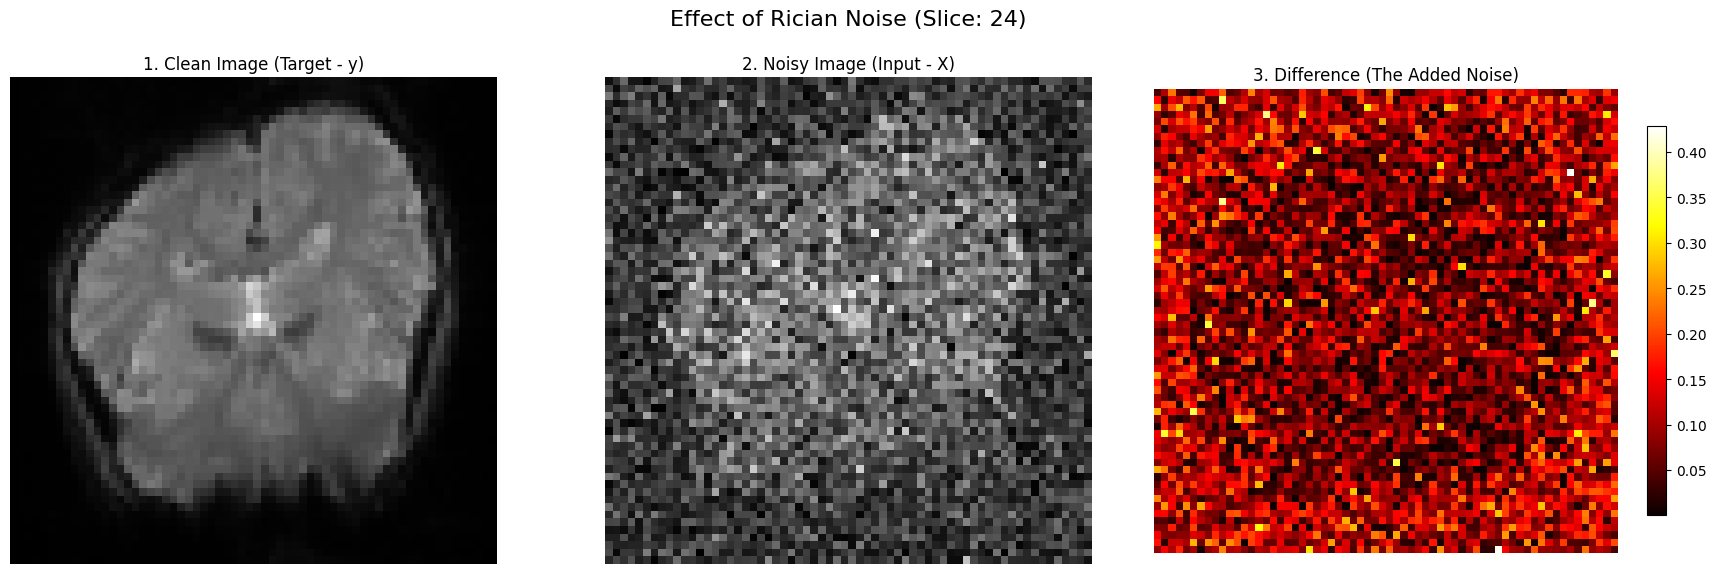

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# --- We copy these utility functions from fMRIDataGenerator ---
def _resample_volume(volume, target_shape):
    """Resamples a 3D volume to the target shape."""
    original_shape = volume.shape
    zoom_factors = [
        target_shape[0] / original_shape[0],
        target_shape[1] / original_shape[1],
        target_shape[2] / original_shape[2]
    ]
    return zoom(volume, zoom_factors, order=1, prefilter=True).astype(np.float32)

def _normalize_volume(volume, v_min, v_max):
    """Normalizes a 3D volume to the [0,1] range."""
    epsilon = 1e-7
    return np.clip((volume - v_min) / (v_max - v_min + epsilon), 0, 1)
# --- End of utility functions ---


# We assume the 'loaded_fmri_data' variable exists
if 'loaded_fmri_data' in locals() and loaded_fmri_data:
    print(" Demonstrating the noise addition process on a sample 3D brain volume...")

    # STEP 1: Select a sample CLEAN 3D brain volume
    # We take the first timepoint from the first file.
    clean_4d_run = loaded_fmri_data[0][1]
    clean_3d_volume_raw = clean_4d_run[:, :, :, 0]
    print(f"   - Original clean volume shape: {clean_3d_volume_raw.shape}")

    # STEP 2: Resample it, just like the generator does
    target_shape = (64, 64, 48) # (Width, Height, Depth)
    clean_volume_resampled = _resample_volume(clean_3d_volume_raw, target_shape)
    print(f"   - Resampled volume shape: {clean_volume_resampled.shape}")

    # STEP 3: Normalize the clean data. This will be our "Target" (y).
    clean_min, clean_max = 0, 3000 # Using the fixed values from our generator
    y_clean_normalized = _normalize_volume(clean_volume_resampled, clean_min, clean_max)
    print(f"   - Clean (Target) data normalized. Value range: [{y_clean_normalized.min():.2f}, {y_clean_normalized.max():.2f}]")

    # STEP 4: Add Rician noise to the clean data. This will be our "Input" (X).
    noise_level = 0.1 # The noise level from our generator
    sigma = noise_level * 1.0 # Since signal is normalized, its max is 1.0
    
    n1 = np.random.normal(0, sigma, size=y_clean_normalized.shape).astype('float32')
    n2 = np.random.normal(0, sigma, size=y_clean_normalized.shape).astype('float32')
    X_noisy_normalized = np.sqrt((y_clean_normalized + n1)**2 + n2**2)
    print(f"   - Rician noise added. New value range: [{X_noisy_normalized.min():.2f}, {X_noisy_normalized.max():.2f}]")


    # STEP 5: Visualize it!
    # Let's select a slice from the middle of the volume
    slice_index = target_shape[2] // 2  # The middle of the depth (48), which is slice 24
    
    y_slice = y_clean_normalized[:, :, slice_index]
    X_slice = X_noisy_normalized[:, :, slice_index]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Effect of Rician Noise (Slice: {slice_index})', fontsize=16)

    # Clean Image
    im0 = axes[0].imshow(np.rot90(y_slice), cmap='gray', origin='lower')
    axes[0].set_title('1. Clean Image (Target - y)', fontsize=12)
    axes[0].axis('off')

    # Noisy Image
    im1 = axes[1].imshow(np.rot90(X_slice), cmap='gray', origin='lower')
    axes[1].set_title('2. Noisy Image (Input - X)', fontsize=12)
    axes[1].axis('off')

    # Difference Image (Just the Noise)
    diff_slice = np.abs(y_slice - X_slice)
    im2 = axes[2].imshow(np.rot90(diff_slice), cmap='hot', origin='lower')
    axes[2].set_title('3. Difference (The Added Noise)', fontsize=12)
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], shrink=0.8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("loaded_fmri_data' not found. Please run the data loading script first.")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import numpy as np
import gc

# ===================================================================
# 1. HELPER BLOCKS: ATTENTION MECHANISM 
# ===================================================================

def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    avg_pool = layers.GlobalAveragePooling3D()(inputs)
    avg_pool = layers.Reshape((1, 1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    max_pool = layers.GlobalMaxPooling3D()(inputs)
    max_pool = layers.Reshape((1, 1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Activation('sigmoid')(attention)
    return layers.Multiply()([inputs, attention])

def spatial_attention(inputs, kernel_size=7):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv3D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    return layers.Multiply()([inputs, attention])

def cbam_block(inputs, ratio=8):
    x = channel_attention(inputs, ratio)
    x = spatial_attention(x)
    return x

# ===================================================================
# 2. THE MAIN MODEL: 3D ATTENTION U-NET WITH LSTM 
# ===================================================================

def build_attention_lstm_unet(input_shape, base_filters=16):
    print(f" Building model with input shape: {input_shape} and base filters: {base_filters}")
    inputs = layers.Input(shape=input_shape)
    # --- ENCODER ---
    conv1 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(inputs))))
    att1 = cbam_block(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att1)
    conv2 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool1))))
    att2 = cbam_block(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att2)
    # --- BOTTLENECK ---
    bottleneck = layers.Conv3D(base_filters * 4, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool2))
    _, D, H, W, F = bottleneck.shape
    bottleneck_reshaped = layers.Reshape((-1, F))(bottleneck)
    lstm_out = layers.Bidirectional(layers.LSTM(base_filters * 2, return_sequences=True))(bottleneck_reshaped)
    lstm_out_reshaped = layers.Reshape((D, H, W, base_filters * 4))(lstm_out)
    # --- DECODER ---
    up3 = layers.Conv3DTranspose(base_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(lstm_out_reshaped)
    merge3 = layers.Concatenate(axis=-1)([up3, att2])
    conv3 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge3))))
    up4 = layers.Conv3DTranspose(base_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv3)
    merge4 = layers.Concatenate(axis=-1)([up4, att1])
    conv4 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge4))))
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(conv4)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# ===================================================================
# 3. TRAINING AND EVALUATION SCRIPT 
# ===================================================================

# Check if the necessary data generator variables exist
if 'train_ds' in globals() and 'val_ds' in globals() and 'test_ds' in globals():
    print("\n" + "="*60)
    print(" STARTING MODEL TRAINING AND EVALUATION")
    print("="*60)
    
    # --- GPU Memory Setup ---
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(" GPU memory growth enabled.")
        except RuntimeError as e:
            print(f"⚠️ Could not set GPU memory growth: {e}")

    # --- Model Definition ---
    input_shape = train_ds.__getitem__(0)[0].shape[1:]
    tf.keras.backend.clear_session()
    gc.collect()
    
    # ADIM 1: Model oluşturuluyor. 'model' değişkeni burada tanımlanıyor.
    model = build_attention_lstm_unet(input_shape=input_shape, base_filters=16)
    model.summary()
    
    # --- Model Compilation ---
    def psnr(y_true, y_pred): return tf.image.psnr(y_true, y_pred, max_val=1.0)
    def ssim(y_true, y_pred): return tf.image.ssim(y_true, y_pred, max_val=1.0)
    
    # ADIM 2: Model derleniyor.
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['mae', psnr, ssim])

    # --- Callbacks ---
    model_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint('best_denoising_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    ]
    
    # --- Start Training ---
    print("\n Training initiated...")
    
    # ADIM 3: Model eğitiliyor. Python artık 'model' değişkenini tanıyor.
    history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=model_callbacks)

    # --- Final Evaluation ---
    print("\n Evaluating the best model on the unseen test set...")
    test_metrics = model.evaluate(test_ds, return_dict=True)
    print("\n Test Set Performance:")
    for key, value in test_metrics.items(): print(f"   - {key}: {value:.4f}")

    # --- Visualize Results ---
    print("\n Visualizing results on a sample from the test set...")
    x_test_sample, y_test_sample = test_ds.__getitem__(0)
    y_pred_sample = model.predict(x_test_sample)
    sample_idx = 0
    slice_idx = x_test_sample.shape[1] // 2
    noisy_img, denoised_img, original_img = x_test_sample[sample_idx, slice_idx, :, :, 0], y_pred_sample[sample_idx, slice_idx, :, :, 0], y_test_sample[sample_idx, slice_idx, :, :, 0]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(np.rot90(noisy_img), cmap='gray', origin='lower'); axes[0].set_title('Noisy Input (X)'); axes[0].axis('off')
    axes[1].imshow(np.rot90(denoised_img), cmap='gray', origin='lower'); axes[1].set_title("Model's Denoised Output"); axes[1].axis('off')
    axes[2].imshow(np.rot90(original_img), cmap='gray', origin='lower'); axes[2].set_title('Ground Truth (y)'); axes[2].axis('off')
    plt.suptitle("Model Denoising Performance on Test Data"); plt.show()

else:
    print(" Data generators ('train_ds', 'val_ds', 'test_ds') not found.")
    print("  Please run the data preparation script first to create these variables.")


🚀 STARTING MODEL TRAINING AND EVALUATION
✅ GPU memory growth enabled.
🧠 Building model with input shape: (48, 64, 64, 1) and base filters: 16


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 64, 64, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 64, 64, 1)  │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 48, 64, 64, 16) │            448 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 64, 64, 16) │             64 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 48, 64, 64, 16) │          6,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling3d      │ (None, 16)             │              0 │ conv3d[0][0]           │
│ (GlobalMaxPooling3D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1, 16)    │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 1, 16)    │              0 │ global_max_pooling3d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 1, 2)     │             34 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 1, 16)    │             48 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 1, 16)    │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 1, 16)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 48, 64, 64, 16) │              0 │ conv3d[0][0],          │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 48, 64, 64, 1)  │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)    

 Total params: 256,135 (1000.53 KB)

 Trainable params: 255,653 (998.64 KB)

 Non-trainable params: 482 (1.88 KB)


🎯 Training initiated...
Epoch 1/50


I0000 00:00:1749417620.559923     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.2654 - mae: 0.0846 - psnr: 23.5468 - ssim: 0.4309
Epoch 1: val_loss improved from inf to 0.19763, saving model to best_denoising_model.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 232s 375ms/step - loss: 0.2653 - mae: 0.0845 - psnr: 23.5560 - ssim: 0.4313 - val_loss: 0.1976 - val_mae: 0.0152 - val_psnr: 32.1188 - val_ssim: 0.7624 - learning_rate: 1.0000e-04
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.1925 - mae: 0.0135 - psnr: 33.0358 - ssim: 0.7948
Epoch 2: val_loss improved from 0.19763 to 0.19543, saving model to best_denoising_model.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 214s 380ms/step - loss: 0.1925 - mae: 0.0135 - psnr: 33.0363 - ssim: 0.7948 - val_loss: 0.1954 - val_mae: 0.0123 - val_psnr: 33.7663 - val_ssim: 0.8226 - learning_rate: 1.0000e-04
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.1917 - mae: 0.0118 - psnr: 33.9629 - ssim: 0.8316
Epoch 3: val_loss improved from 0.19543 to 0.19493, saving model 

📊 Generating training history plots...


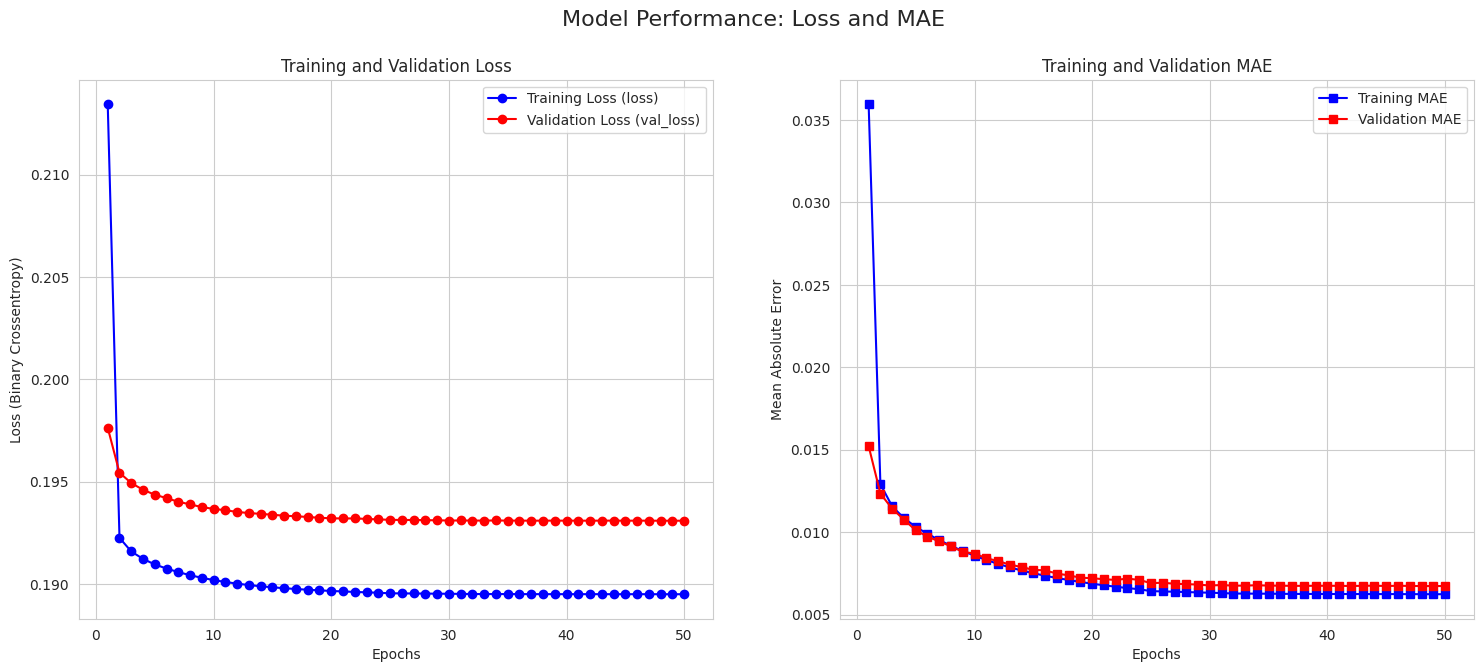

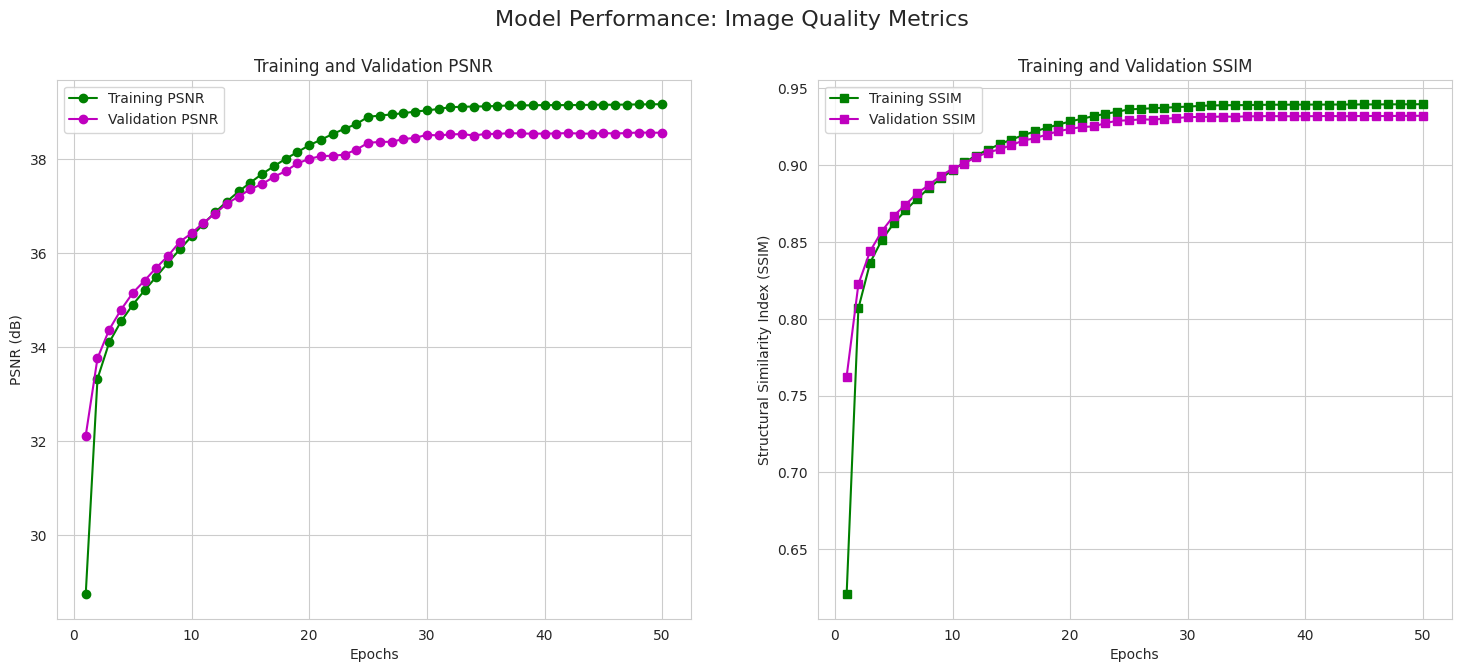

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the 'history' object from model.fit() exists
if 'history' in globals():
    print("📊 Generating training history plots...")

    # Set a nice style for the plots
    sns.set_style("whitegrid")

    # Get the metrics from the history object
    history_dict = history.history
    
    epochs = range(1, len(history_dict['loss']) + 1)

    # --- 1. Plot for Loss and MAE ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Model Performance: Loss and MAE', fontsize=16)

    # Plot Training & Validation Loss
    ax1.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss (loss)')
    ax1.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss (val_loss)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (Binary Crossentropy)')
    ax1.legend()

    # Plot Training & Validation MAE
    ax2.plot(epochs, history_dict['mae'], 'bs-', label='Training MAE')
    ax2.plot(epochs, history_dict['val_mae'], 'rs-', label='Validation MAE')
    ax2.set_title('Training and Validation MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.legend()
    
    plt.show()

    # --- 2. Plot for PSNR and SSIM ---
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Model Performance: Image Quality Metrics', fontsize=16)

    # Plot Training & Validation PSNR
    ax3.plot(epochs, history_dict['psnr'], 'go-', label='Training PSNR')
    ax3.plot(epochs, history_dict['val_psnr'], 'mo-', label='Validation PSNR')
    ax3.set_title('Training and Validation PSNR')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('PSNR (dB)')
    ax3.legend()

    # Plot Training & Validation SSIM
    ax4.plot(epochs, history_dict['ssim'], 'gs-', label='Training SSIM')
    ax4.plot(epochs, history_dict['val_ssim'], 'ms-', label='Validation SSIM')
    ax4.set_title('Training and Validation SSIM')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Structural Similarity Index (SSIM)')
    ax4.legend()

    plt.show()

else:
    print(" history' object not found.")
    print(" Please make sure the model training cell has been run successfully.")

📸 Visualizing model performance on a sample from the unseen test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


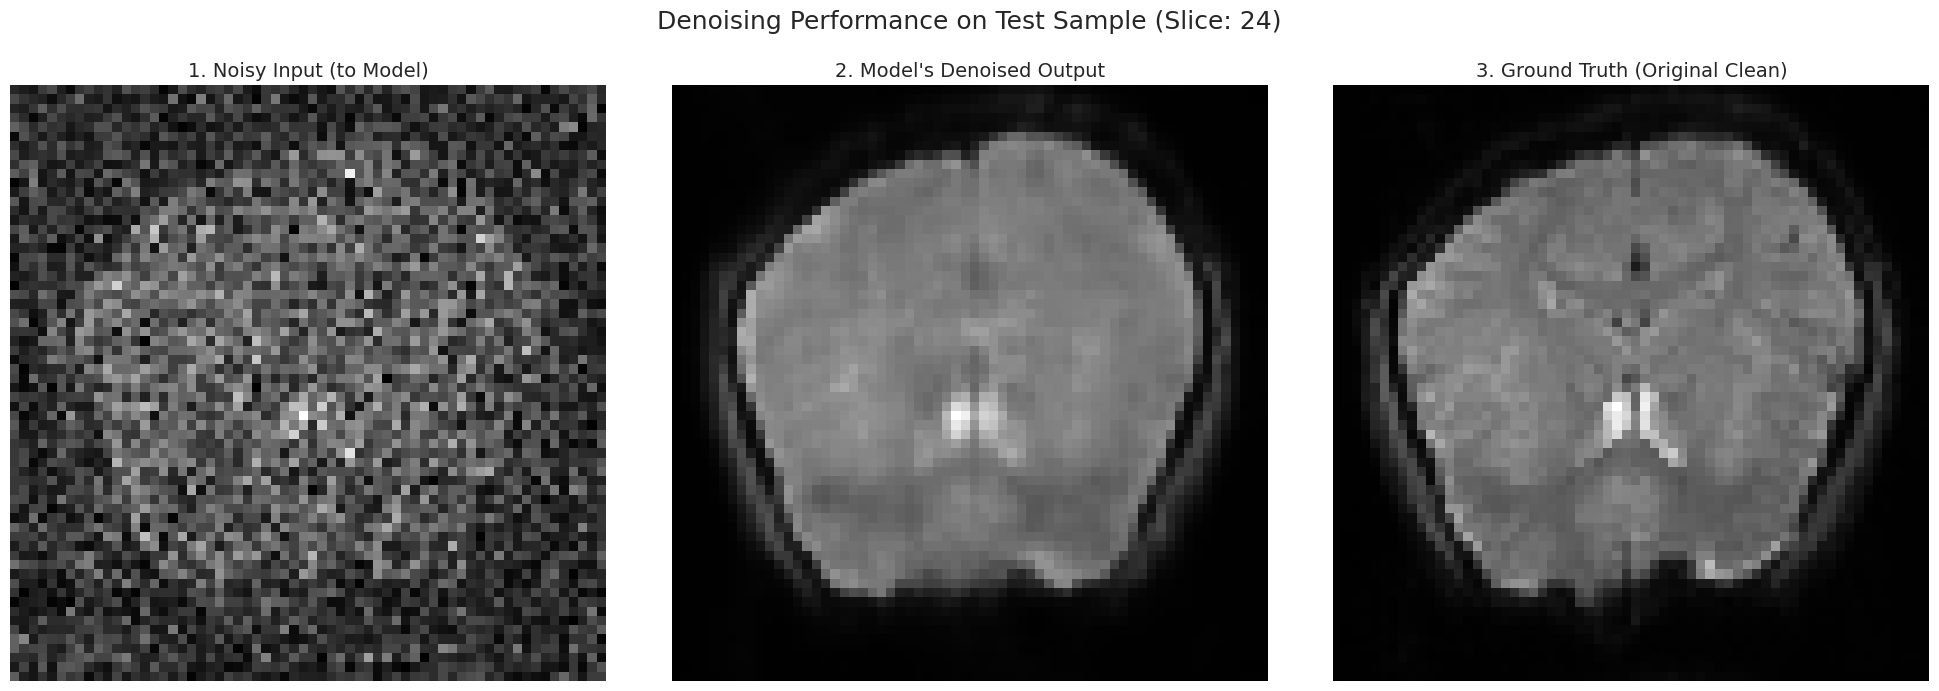

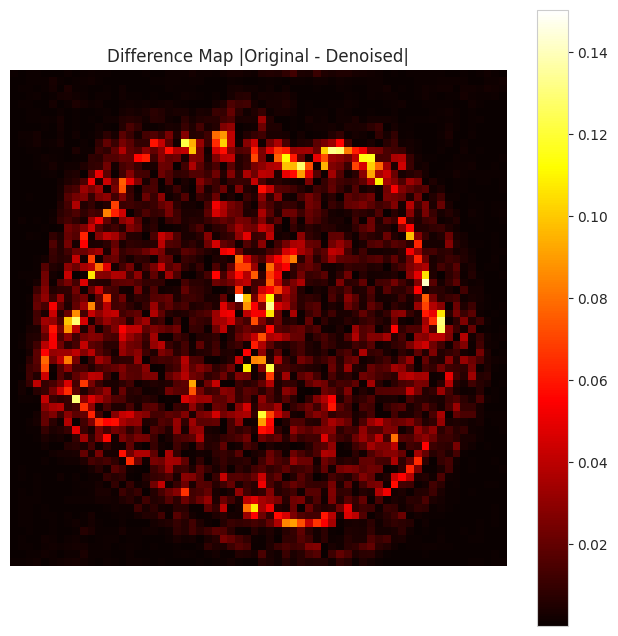

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Check if the necessary variables 'model' and 'test_ds' exist
if 'model' in globals() and 'test_ds' in globals():
    print(" Visualizing model performance on a sample from the unseen test set...")

    # Get one batch of data from the test generator
    # We getitem[0] to get the first batch
    x_test_sample_batch, y_test_sample_batch = test_ds.__getitem__(0)
    
    # Use the trained model to make predictions on this batch
    y_pred_sample_batch = model.predict(x_test_sample_batch)

    # --- Let's display the first sample from the batch ---
    sample_to_display_idx = 0 
    
    # Get the middle slice of the 3D volume for visualization
    # Shape is (batch, depth, height, width, channels) -> We need the depth index
    slice_idx = x_test_sample_batch.shape[1] // 2 

    # Extract the 2D slices for visualization
    noisy_img = x_test_sample_batch[sample_to_display_idx, slice_idx, :, :, 0]
    denoised_img = y_pred_sample_batch[sample_to_display_idx, slice_idx, :, :, 0]
    original_img = y_test_sample_batch[sample_to_display_idx, slice_idx, :, :, 0]

    # --- Plotting the results ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    fig.suptitle(f"Denoising Performance on Test Sample (Slice: {slice_idx})", fontsize=18)

    # 1. Noisy Input
    axes[0].imshow(np.rot90(noisy_img), cmap='gray', origin='lower')
    axes[0].set_title('1. Noisy Input (to Model)', fontsize=14)
    axes[0].axis('off')

    # 2. Denoised Output
    im = axes[1].imshow(np.rot90(denoised_img), cmap='gray', origin='lower')
    axes[1].set_title("2. Model's Denoised Output", fontsize=14)
    axes[1].axis('off')

    # 3. Ground Truth
    axes[2].imshow(np.rot90(original_img), cmap='gray', origin='lower')
    axes[2].set_title('3. Ground Truth (Original Clean)', fontsize=14)
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # --- Optional: Difference Map ---
    # To see what the model removed/changed
    diff_map = np.abs(original_img - denoised_img)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.rot90(diff_map), cmap='hot')
    plt.title('Difference Map |Original - Denoised|')
    plt.colorbar()
    plt.axis('off')
    plt.show()


else:
    print(" model' or 'test_ds' object not found.")
    print(" Please make sure the model training cell has been run successfully.")

In [23]:
!ls -lh /kaggle/working/

total 3.2M
-rw-r--r-- 1 root root 3.2M Jun  9 00:18 best_denoising_model.keras
